In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 11a:

## Tensor Flow
- multi-class - Fashion MNIST dataset (all 70000 images)
- No regularization

<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###------------------
### Import Statements
###------------------

# TensorFlow
import tensorflow as tf

import os
from time import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

print(tf.__version__)

2023-07-10 08:06:05.833368: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 08:06:07.060700: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.0


In [3]:
# Some basic parameters

inpDir = os.path.join('..', '..', 'input') # location where input data is stored
outDir = '../output' # location to store outputs
subDir = 'fashion_MNIST' # location of the images
modelDir = '../models'
altName = 'no_frils'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production


EPOCHS = 20 # number of cycles to run
ALPHA = 0.1 # learning rate

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (9,9),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }
CMAP = plt.cm.brg
plt.rcParams.update(params) # update rcParams

## Helper Function

In [4]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

## Load Fashion MNIST dataset

This notebook uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and [load the Fashion MNIST data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) directly from TensorFlow:

In [5]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [6]:
class_names = {0: 'T-shirt/top',
               1: 'Trouser',
               2: 'Pullover',
               3: 'Dress',
               4: 'Coat',
               5: 'Sandal', 
               6: 'Shirt',
               7: 'Sneaker', 
               8: 'Bag', 
               9: 'Ankle boot'}

## Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, with each image represented as 28 x 28 pixels:

In [7]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
train_df.shape, test_df.shape

((60000, 785), (10000, 785))

Each label is an integer between 0 and 9:

In [9]:
train_df['label'].unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1])

## Whats in the data?

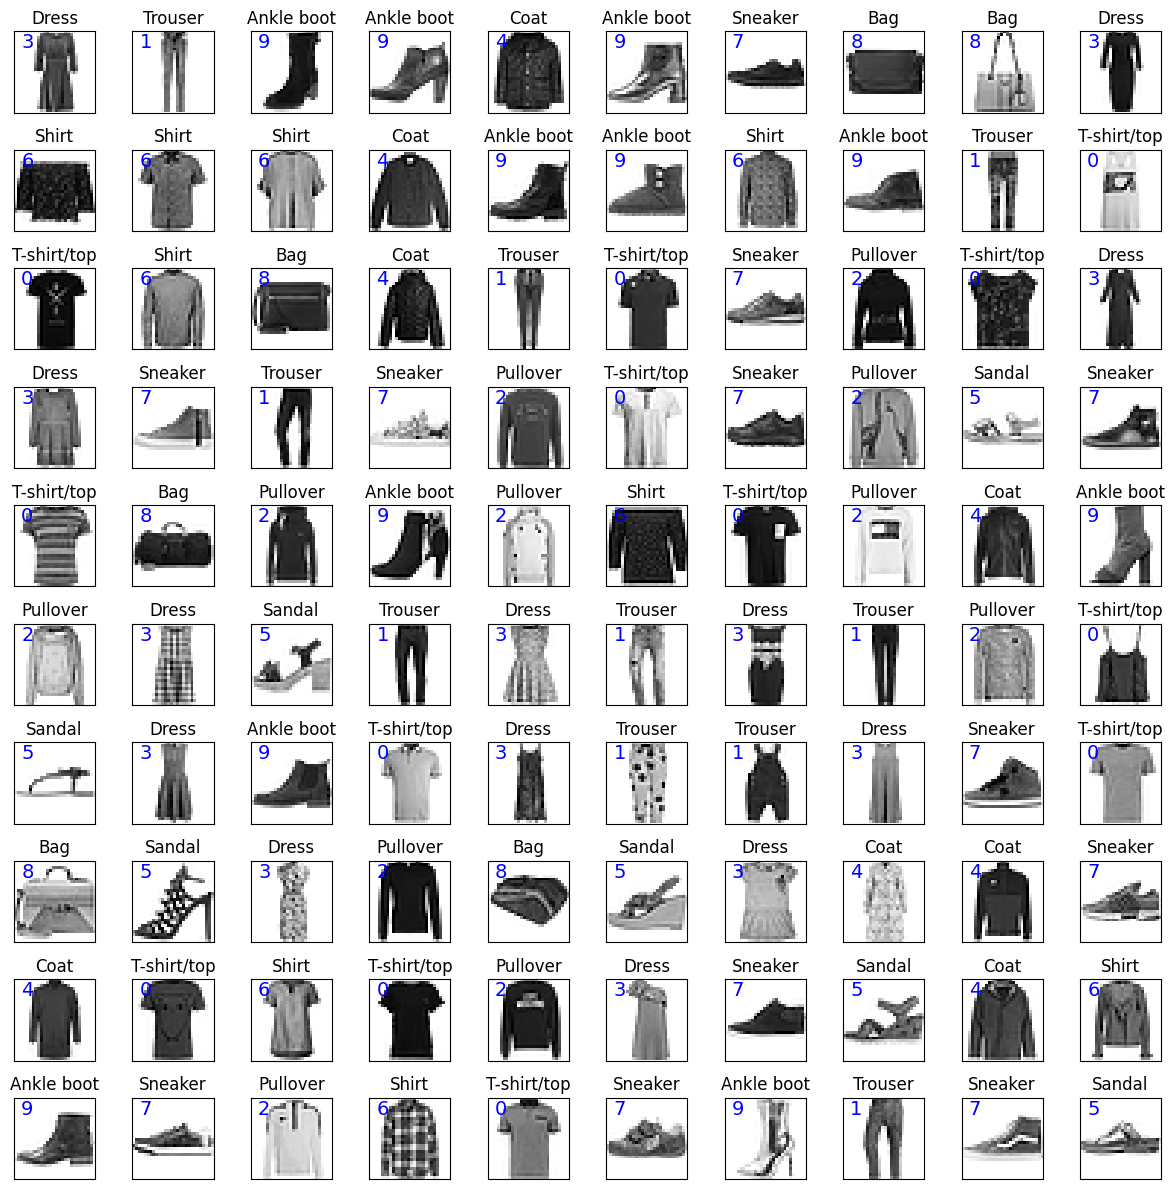

In [32]:
# Sample data plot

plot_df = train_df.sample(n = 100) # Take 100 sample from the training set

fig = plt.figure(figsize=(12, 12))  # figure size in inches

i = 0

for _ , row in plot_df.iterrows(): # iterate through all rows of the dataframe
    
    i = i + 1
    
    image = row.values[1:].reshape(28,28) # reshape row to a 28x28 matrix
    
    ax = fig.add_subplot(10, 10, (i), xticks=[], yticks=[]) # add a subplot to the figure
    
    ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest') # show image on the axis
    
    ax.text(2, 5, str(row[0]), color='b', fontsize=14)   # add number (class) of the image
    
    ax.set_title(class_names[row[0]], fontsize=12)   # add name of the image

plt.tight_layout()
plt.show()

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the *training set* and the *testing set* be preprocessed in the same way:

In [11]:
X_train = train_df.drop('label', axis = 1).to_numpy()
y_train = train_df['label'].to_numpy()

X_test = test_df.drop('label', axis = 1).to_numpy()
y_test = test_df['label'].to_numpy()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [12]:
X_train = X_train / 255.0

X_test = X_test / 255.0

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

In [13]:
def build_model():
    
    model = tf.keras.Sequential([ # Assumes Input based on X_train
        
        tf.keras.layers.Dense(196,
                             activation='relu'), # Hidden1
        
        
        tf.keras.layers.Dense(49,
                             activation='relu'), # Hidden 2
        
         tf.keras.layers.Dense(10) # output layer

    ])
    
    model.compile(optimizer = 'adam',
                 loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics = ['accuracy'])
    
    return model

In [14]:
# Create a basic model instance
model = build_model()

2023-07-10 08:06:14.751076: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-10 08:06:14.794568: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-10 08:06:14.794752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [15]:
# model.summary()

## Train the model


First define call backs

In [16]:
#checkpoint_dir = 'model'
checkpoint_dir = os.path.join(modelDir, subDir)

checkpoint_prefix = os.path.join(checkpoint_dir, altName)

model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                                    monitor='val_loss',
                                                    mode='auto',
                                                    save_weights_only=True,
                                                    save_best_only=True,
                                                    verbose=1)

In [17]:
history = model.fit(X_train, y_train,
                    validation_data=[X_test, y_test],
                    epochs=EPOCHS,
                    callbacks=[model_callback])

Epoch 1/20


2023-07-10 08:06:16.485997: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-10 08:06:16.487508: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fefccc94f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-10 08:06:16.487521: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-07-10 08:06:16.490583: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-10 08:06:17.694133: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8901
2023-07-10 08:06:17.803116: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

1848/1875 [============================>.] - ETA: 0s - loss: 0.4967 - accuracy: 0.8223
Epoch 1: val_loss improved from inf to 0.40299, saving model to ../models/fashion_MNIST/no_frils
1875/1875 [==============================] - 7s 2ms/step - loss: 0.4955 - accuracy: 0.8228 - val_loss: 0.4030 - val_accuracy: 0.8584
Epoch 2/20
1849/1875 [============================>.] - ETA: 0s - loss: 0.3711 - accuracy: 0.8641
Epoch 2: val_loss improved from 0.40299 to 0.36732, saving model to ../models/fashion_MNIST/no_frils
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3702 - accuracy: 0.8644 - val_loss: 0.3673 - val_accuracy: 0.8621
Epoch 3/20
1849/1875 [============================>.] - ETA: 0s - loss: 0.3376 - accuracy: 0.8766
Epoch 3: val_loss improved from 0.36732 to 0.34322, saving model to ../models/fashion_MNIST/no_frils
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3372 - accuracy: 0.8767 - val_loss: 0.3432 - val_accuracy: 0.8747
Epoch 4/20
1856/187

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 196)               153860    
                                                                 
 dense_1 (Dense)             (None, 49)                9653      
                                                                 
 dense_2 (Dense)             (None, 10)                500       
                                                                 
Total params: 164013 (640.68 KB)
Trainable params: 164013 (640.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
hist_df = pd.DataFrame(history.history)
hist_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.495471,0.822800,0.402994,0.8584
1,0.370219,0.864400,0.367324,0.8621
2,0.337248,0.876733,0.343215,0.8747
3,0.313979,0.884067,0.339302,0.8751
4,0.293842,0.890317,0.321009,0.8826


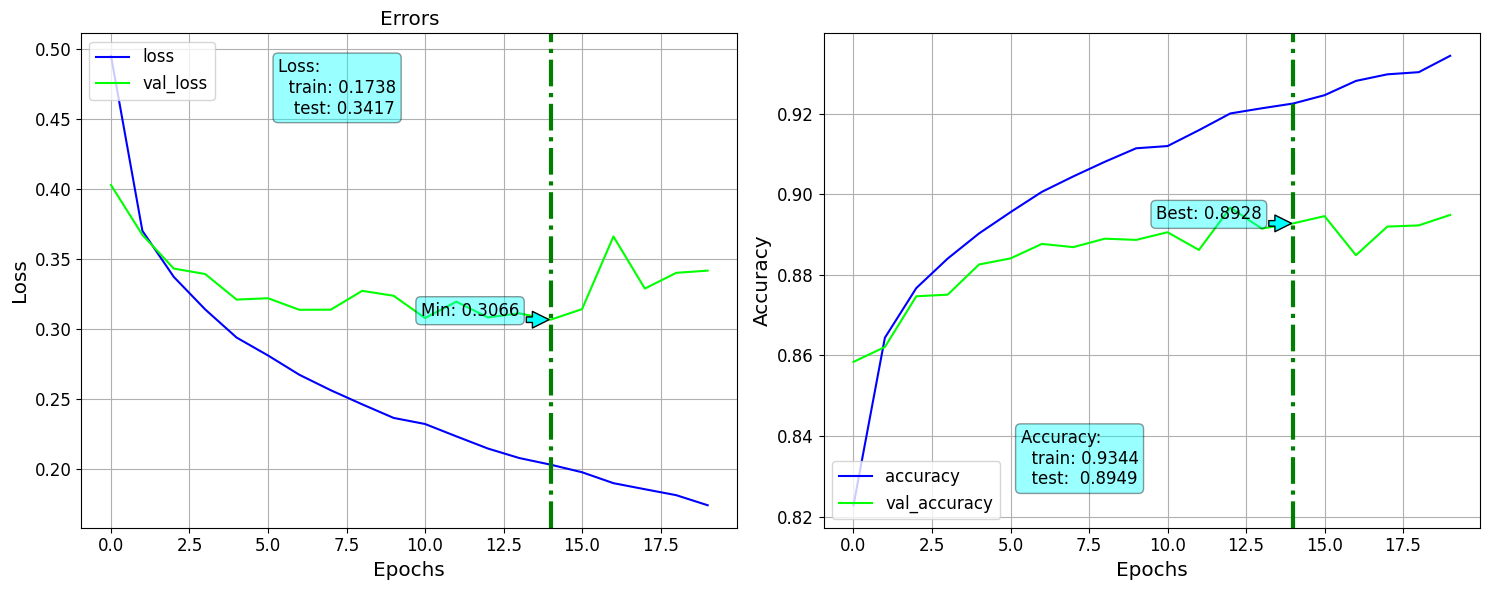

In [20]:
fn_plot_tf_hist(hist_df)

### Evaluate accuracy

Next, compare how the model performs on the test dataset:

In [21]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 0.3417 - accuracy: 0.8949 - 459ms/epoch - 1ms/step

Test accuracy: 0.8949000239372253


### Make predictions

In [22]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [23]:
predictions = probability_model.predict(X_test)

313/313 [==============================] - 0s 840us/step


In [24]:
predictions.shape

(10000, 10)

In [25]:
predictions[0].sum()

1.0000001

In [26]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'../models/fashion_MNIST/no_frils'

In [27]:
# Create a new model instance
model1 = build_model()

# Load the previously saved weights
model1.load_weights(latest)

# Re-evaluate the model
loss, acc = model1.evaluate(X_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

313/313 - 0s - loss: 0.3066 - accuracy: 0.8928 - 420ms/epoch - 1ms/step
Restored model, accuracy: 89.28%


In [28]:
y_pred = model1.predict(X_test)
y_pred.shape

313/313 [==============================] - 0s 916us/step


(10000, 10)

### Argmax will give us class

In [29]:
cm  = confusion_matrix(y_test, np.argmax(y_pred, axis = 1))
cm

array([[850,   0,  13,  24,   2,   2, 102,   0,   7,   0],
       [  2, 987,   0,   9,   0,   0,   2,   0,   0,   0],
       [ 12,   0, 766,  18, 122,   0,  77,   0,   5,   0],
       [ 21,  10,   5, 928,  15,   1,  17,   0,   3,   0],
       [  0,   1,  47,  50, 838,   0,  63,   0,   1,   0],
       [  1,   0,   0,   0,   0, 962,   0,  23,   3,  11],
       [141,   3,  46,  30,  51,   0, 719,   0,  10,   0],
       [  0,   0,   0,   0,   0,  18,   0, 929,   1,  52],
       [  4,   0,   2,   2,   4,   2,   3,   1, 982,   0],
       [  0,   0,   0,   0,   0,  11,   0,  22,   0, 967]])

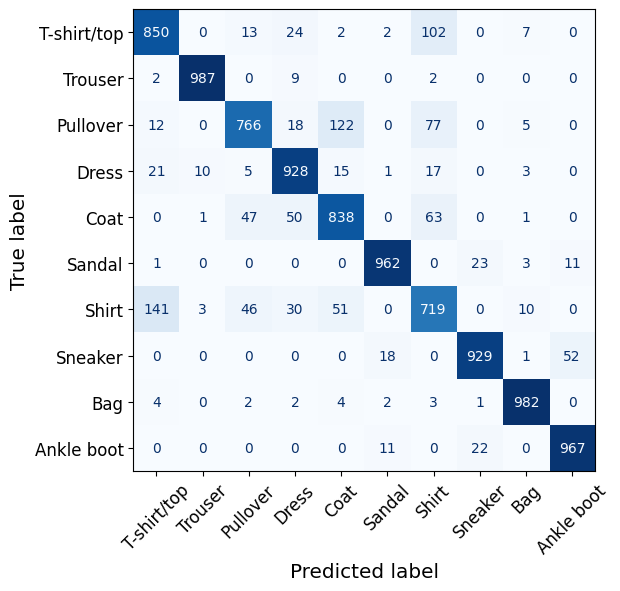

In [30]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names.values())

fig, ax = plt.subplots(figsize = (6,6))

disp.plot(ax = ax, cmap = 'Blues', colorbar=False, xticks_rotation=45)

plt.show();

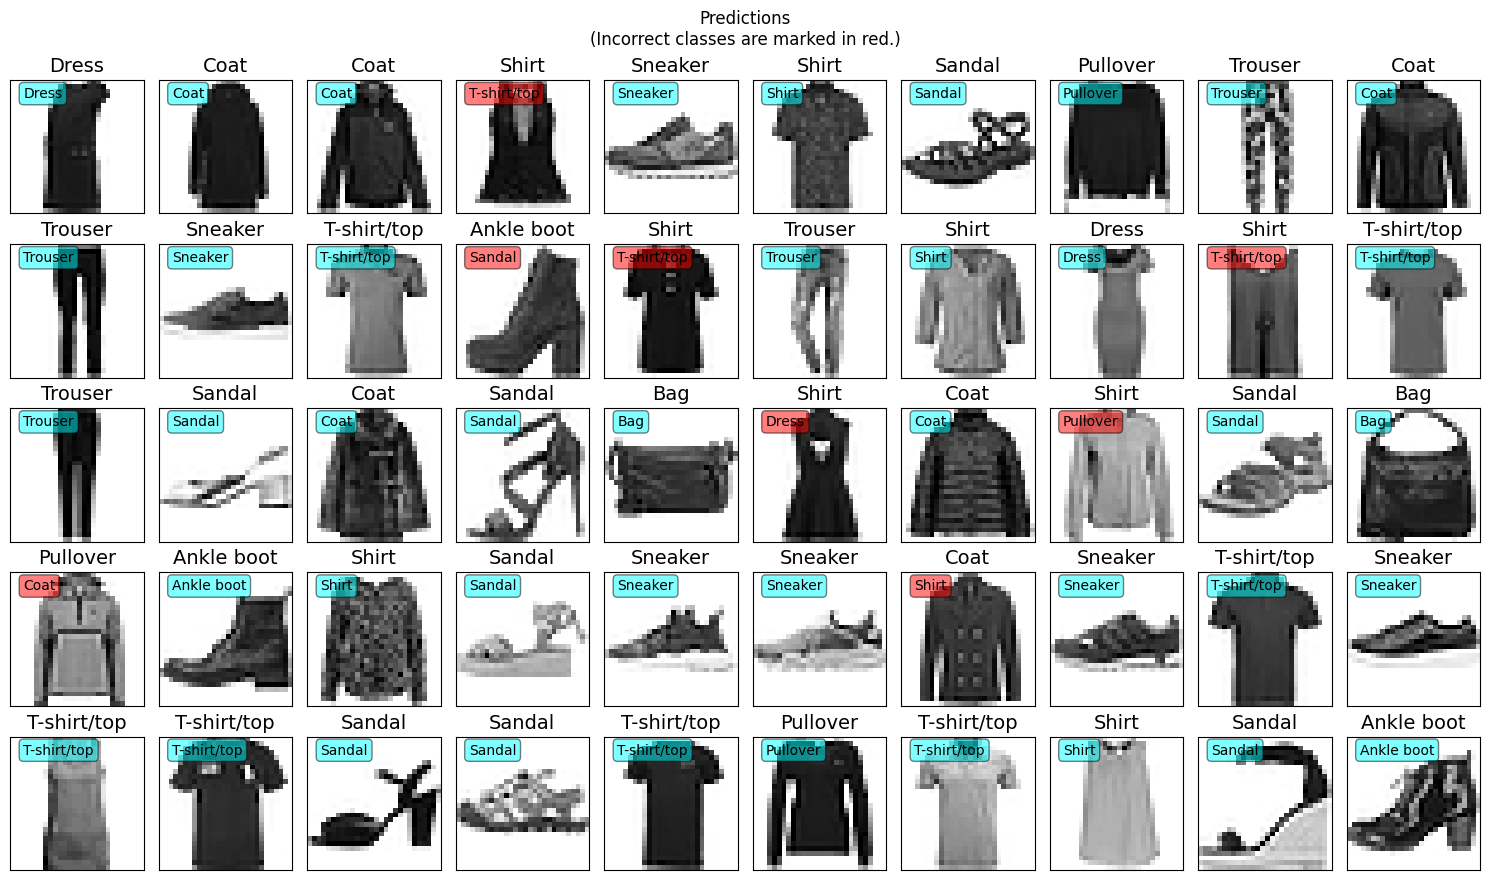

In [35]:
# Results data plot

test_df['y_pred'] = np.argmax(y_pred, axis = 1)

plot_df = test_df.sample(n = 50) # Take 50 sample from the training set

fig = plt.figure(figsize=(15, 9))  # figure size in inches

i = 0

fntsize = 14

for _, row in plot_df.iterrows(): # iterate through all rows of the dataframe
    
    i = i + 1
    
    image = row.values[1:-1].reshape(28,28) # reshape row to a 28x28 matrix
    
    if row[0]!= row[-1]:
        color = 'red'
    else:
        color = 'cyan'

    props = dict(boxstyle='round', facecolor=color, alpha=0.5)
    
    ax = fig.add_subplot(5, 10, (i), xticks=[], yticks=[]) # add a subplot to the figure
    
    ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest') # show image on the axis
    
    ax.set_title(class_names[row[0]], fontsize=fntsize)   # add number (class) of the image
    
    ax.text(0.1, 0.95, class_names[row[-1]], transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)   # add number (class) of the image
    
fig.suptitle('Predictions\n(Incorrect classes are marked in red.)')
plt.tight_layout()
plt.show()